In [1]:
# Packages
import torch          # handeling general math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
import matplotlib.pyplot as plt
import ot             # for optimal transport W2-distance
import os             # crating folders (can be disabled when manulay creating folders)
from time import time # acces to system time

Device: cuda


In [2]:
os.makedirs("Snapshots", exist_ok = True)
os.makedirs("Wasserstein_Error", exist_ok = True)

# Theoretical background

Let the kernel be given by $K(x,y) = F(\|x - y\|)$. Assume to have probability measures $\mu, \nu$ of the form

$$ \mu = \frac{1}{m} \sum_{k=1}^m \delta_{x_k} \quad \text{ and } \quad \nu = \frac{1}{n} \sum_{k=1}^n \delta_{y_k} $$

The MMD squared between $\mu$ and $\nu$ is given by

$$ \text{MMD}(x) = \|\mu - \nu\|_K^2 = \frac{1}{m^2} \sum_{k,j=1}^m F(\|x_k - x_j\|) - \frac{2}{mn} \sum_{k=1}^m \sum_{j=1}^n F(\|x_k - y_j\|) + \|\nu\|_K^2 $$

The scaled gradient of $\|\mu - \nu\|_K^2$ with respect to $x$ is given by

$$ \partial_{x_j} \text{MMD}(x) = \frac{2}{m} \sum_{k=1, k \neq j}^m \frac{x_j - x_k}{\|x_j - x_k\|} F'(\|x_j - x_k\|) - \frac{2}{n} \sum_{k=1}^n \frac{x_j - y_k}{\|x_j - y_k\|} F'(\|x_j - y_k\|) $$

Setting $\tilde{F}(s) \coloneqq \frac{F'(s)}{s}$, we obtain

$$ \partial_{x_j} \text{MMD}(x) = \frac{2}{m} \sum_{k=1}^m (x_j - x_k) \tilde{F}(\|x_j - x_k\|) - \frac{2}{n} \sum_{k=1}^n (x_j - y_k) \tilde{F}(\|x_j - y_k\|) $$
Given fixed targets $\nu$ as points $\texttt{torch.tensor([2,n])}$ we approximate the Wasserstein Gradient Flow from a given prior $\mu$ of same shape, by performing gradient descent on the MMD


In [3]:
# Compute gradient of MMD
def nabla_MMD(X,Y, tildeF):
    """
    X : torch.tensor, shape = (2, m) points of mu.
    Y : torch.tensor, shape = (2, n) points of nu.
    return: torch.tensor, shape (2,n) Gradient of MMD
    """
    m = X.shape[1]
    n = Y.shape[1]
    inter = X[:,None,:]- X[:,:,None]
    inter =  2/m * torch.sum(inter * tildeF(torch.linalg.norm(inter, dim = 0)), dim = 1)

    attrac = X[:,None,:] - Y[:,:,None]
    attrac = 2/n * torch.sum(attrac * tildeF(torch.linalg.norm(attrac, dim = 0)), dim = 1)
    return inter - attrac

# Radial Basis Functions (RBF) $F$
### Gaussian kernel (Gauss):
$$F(s):=\exp(-\frac{s^2}{2\sigma^2})\qquad \text{ with } \qquad \tilde F(s)=-\frac{1}{\sigma^2}\exp\left(-\frac{s^2}{2\sigma^2}\right)$$
### Smoothed distance kernel (SND):
$$ \tilde F(s):=-\mathcal S_3[\textup{abs}*M_2] \qquad \text{ with } \qquad \tilde F(s) =-\begin{cases} -\frac{1}{4} |s|+\frac{2}{3}& \text{ if } |s|\le 1\\ \frac{1}{2s}-\frac{1}{12s^3}& \text{ if } |s|>1
\end{cases}\qquad \text{ and } \qquad  \tilde F_\sigma(s)=\frac{1}{\sigma} \tilde F(\frac{s}{\sigma})$$
### Negative distance kernel (ND):
$$ \tilde F(s):=-\frac{1}{2} |s| \qquad \text{ with }\qquad  \tilde F(s) =-\begin{cases} 0 & \text{ if } s =0\\ \frac{1}{2s}& \text{ if } |s|>0
\end{cases}$$

In [4]:
def tilde_Gauss(s, sigma = .1):
    return -1/sigma**2 * torch.exp(-s**2/(2*sigma**2))

def tilde_SND(s, sigma = 100):
    s = torch.abs(s*1/sigma)
    return -1/sigma * torch.where(s<=1, -1/4 *s+2/3, 1/(2*s)-1/(12*s**3))

def tilde_ND(s, sigma = None):
    s= torch.abs(s)
    return - 1/2*torch.where(s==0, 0, 1/s)

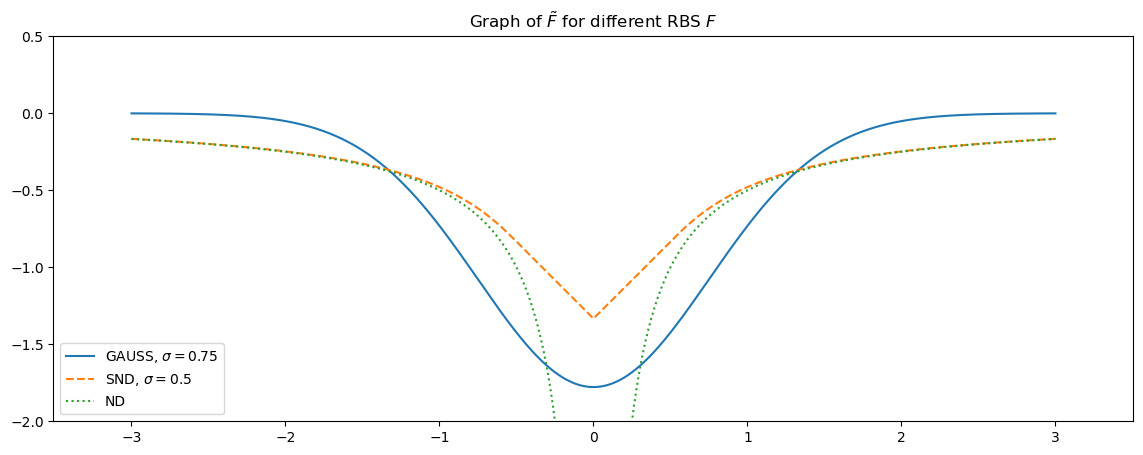

In [5]:
S = torch.linspace(-3,3,6001)
Gauss = tilde_Gauss(S, sigma = .75)
SND = tilde_SND(S,sigma = .5)
ND = tilde_ND(S)

plt.figure(figsize = (12, 5))
plt.plot(S,Gauss, label = r"GAUSS, $\sigma = 0.75$")
plt.plot(S,SND, label = r"SND, $\sigma = 0.5$", linestyle = "--")
plt.plot(S,ND, label = "ND", linestyle = ":")
plt.axis("equal")
plt.ylim([-2,.5])
plt.xlim([-3, 3])
plt.legend()
plt.title(r"Graph of $\tilde F$ for different RBS $F$")
plt.subplots_adjust(left = 0)
plt.show()

# Generating targets and priors

In [6]:
# Data generation
def generate_circle(M, r = 1, mean = [0,0]):
    # Generate circle centered at mean with radius r on M equidistant points of shape torch.tensor([2,M])
    mean = torch.tensor(mean)
    theta = torch.linspace(0, 2 * torch.pi, M + 1)[:-1]  # Remove last point to avoid duplication
    circle = r *torch.stack([ torch.cos(theta), torch.sin(theta)], dim=1) + mean
    return circle.T

def generate_gaussian(N, st = 42, mean = [0,0.]):
    # Generate N Gaussian samples of variance 1e-4 at mean of shape torch.tensor([2,N])
    mean = torch.tensor(mean)
    torch.manual_seed(st)
    normal = torch.distributions.MultivariateNormal(mean, 1e-4 * torch.eye(2))
    prior = normal.sample((N,))
    return prior.T

def generate_bananas(M, st = 42):
    # generate two banans next to each other of shape torch.tensor([2,M])
    u = int(M / 2)
    torch.manual_seed(st)  # fix randomness

    # layer 1
    vert1 = torch.rand(u)
    hori1 = torch.rand(u)
    xs1 = torch.linspace(-1, 1, u) + vert1
    squared1 = xs1**2 + hori1

    # layer 2
    vert2 = torch.rand(u)
    hori2 = torch.rand(u)
    xs2 = torch.linspace(-1.5, 1.5, u) + vert2
    squared2 = 1/2*(xs2 - 1)**2 + hori2 - 4

    xs = torch.cat((xs1, xs2))
    squared = torch.cat((squared1, squared2))
    target = torch.stack((squared, xs))

    return target

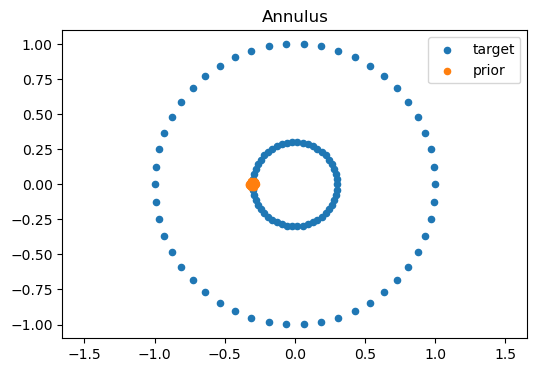

In [7]:
# Target 01: Annulus - two circles with radius 1 and 0.3 centered at 0. Each consisting of 50 points
num_points = 50 # total 50 * 2 = 100
outer_circle = generate_circle(num_points, r = 1, mean = [0,0])
inner_circle = generate_circle(num_points, r = 0.3, mean = [0,0])
target01 = torch.cat([outer_circle,inner_circle], dim = 1 )
prior01 = generate_gaussian(2 * num_points, mean = [-0.3, 0.])

plt.figure(figsize = (6, 4))
plt.scatter(target01[0], target01[1], s = 20, label = "target")
plt.scatter(prior01[0], prior01[1], s = 20, label = "prior")
plt.axis("equal")
plt.title("Annulus")
plt.legend()
plt.savefig(f"Wasserstein_Error/Annulus", dpi = 300, bbox_inches = 'tight', pad_inches = 0, transparent = False)
plt.show()

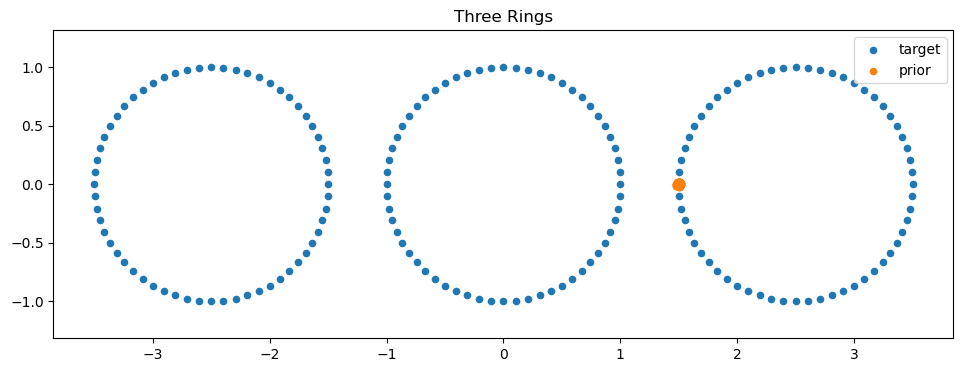

In [8]:
# Target 02: Three Circles - each consisting of 60 points with radius 1 and centered at x = -2,5 0, 2.5 and y = 0,0,0
num_points = 60 # total 60 * 3 = 120
center_circle = generate_circle(num_points, r = 1, mean = [0, 0])
left_circle = generate_circle(num_points, r = 1, mean = [-2.5, 0])
right_circle = generate_circle(num_points, r=1, mean = [2.5, 0])
target02 = torch.cat([left_circle, center_circle, right_circle], dim = 1)
prior02 = generate_gaussian(3*num_points, mean = [1.5, 0.])

plt.figure(figsize = (10, 4))
plt.scatter(target02[0], target02[1], s = 20, label = "target")
plt.scatter(prior02[0], prior02[1], s = 20, label = "prior")
plt.axis("equal")
plt.title("Three Rings")
plt.subplots_adjust(left = 0)
plt.legend(loc="upper right")
plt.savefig(f"Wasserstein_Error/Three_Rings", dpi = 300, bbox_inches = 'tight', pad_inches = 0, transparent = False)
plt.show()

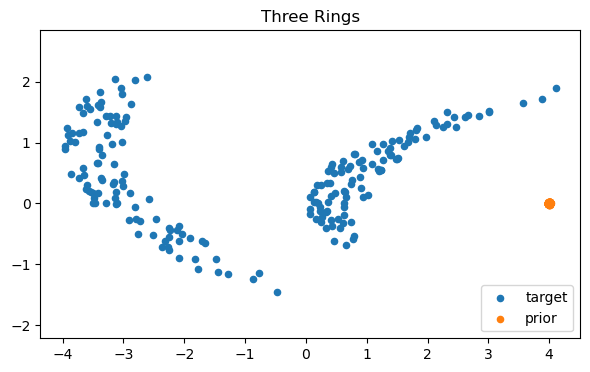

In [9]:
# Target 03: Bananas - each consisting of 100 points
num_points = 200
target03 = generate_bananas(num_points)
prior03 = generate_gaussian(num_points, mean = [4, 0.])

plt.figure(figsize = (6, 4))
plt.scatter(target03[0], target03[1], s = 20, label = "target")
plt.scatter(prior03[0], prior03[1], s = 20, label = "prior")
plt.axis("equal")
plt.title("Three Rings")
plt.subplots_adjust(left = 0)
plt.legend(loc="lower right")
plt.savefig(f"Wasserstein_Error/Bananas", dpi = 300, bbox_inches = 'tight', pad_inches = 0, transparent = False)

plt.show()

# Setting Target and function dependend paramters

In [10]:
# Target depending parameters:
Targets =[target01, target02, target03]
Priors = [prior01, prior02, prior03]
Target_names =["Annulus", "Three_Rings", "Bananas"]
Tau = [0.03, 0.1, 0.2]                    # stepsize for each experiment

# function depending parameters
Sigma_Gauss = [0.06, 0.3, 1]
Sigma_SND = [0.001, 0.01, 0.1, 0.0001, 1] # coresponds to epsilon
Sigma_ND = [""]                           # negative distance kernel has no paramter
Sigmas = [Sigma_Gauss, Sigma_SND, Sigma_ND]
Functions =[tilde_Gauss, tilde_SND,tilde_ND]
Function_names = ["GAUSS", "SND", "ND"]

it = 5000 + 1                            # iterations
snaps = [0, 100, 500, 1000, 5000, 10000]
snaps = [x for x in snaps if x <= it]     # snaps of curent iteration for plotting flow 
Flow, Dist = [], []                       # storing evolution of flow

# Computing Wasserstein Gradient Flow of MMD functional

In [11]:
time_start, time_prev = time(), time()
for t, p, target_name, tau in zip(Targets, Priors, Target_names, Tau):
    print("Target: ", target_name, tau)
    num_points = t.shape[1]
    Flow01, Dist01 = [], []
    
    for func, func_name, Sigma in zip(Functions, Function_names, Sigmas):
        print("    Function: ", func_name)
        Flow02, Dist02 = [], []
        
        for sigma in Sigma:
            print("        Parameter: ", sigma)
            tildeF = lambda s: func(s,sigma)
            Flow03, Dist03 = [], torch.zeros(it)
            target= t.to(device)
            prior = p.to(device)
            
            for k in range(it):
                if k in snaps: Flow03.append(prior.to("cpu")) # snap of curent iteration of WGF
                Dist03[k] = ot.emd2([], [], ot.dist(prior.T, target.T, metric = 'sqeuclidean')) # W2^2 distance between target and flow
                prior -= tau * nabla_MMD(prior, target, tildeF) # update flow to next step
                
            Flow02.append(Flow03)
            Dist02.append(torch.sqrt(Dist03)) # W2 distance evolution
        Flow01.append(Flow02)
        Dist01.append(Dist02)
    Flow.append(Flow01)
    Dist.append(Dist01)
    print("    Time: ", time()-time_prev, " seconds\n")
    time_prev = time()
print("Total time: ", time()-time_start)

Target:  Annulus 0.03
    Function:  GAUSS
        Parameter:  0.06
        Parameter:  0.3
        Parameter:  1
    Function:  SND
        Parameter:  0.001
        Parameter:  0.01
        Parameter:  0.1
        Parameter:  0.0001
        Parameter:  1
    Function:  ND
        Parameter:  
    Time:  80.1051115989685  seconds

Target:  Three_Rings 0.1
    Function:  GAUSS
        Parameter:  0.06
        Parameter:  0.3
        Parameter:  1
    Function:  SND
        Parameter:  0.001
        Parameter:  0.01
        Parameter:  0.1
        Parameter:  0.0001
        Parameter:  1
    Function:  ND
        Parameter:  
    Time:  160.61857962608337  seconds

Target:  Bananas 0.2
    Function:  GAUSS
        Parameter:  0.06
        Parameter:  0.3
        Parameter:  1
    Function:  SND
        Parameter:  0.001
        Parameter:  0.01
        Parameter:  0.1
        Parameter:  0.0001
        Parameter:  1
    Function:  ND
        Parameter:  
    Time:  191.04569840431213  s

# Visualization

In [12]:
Lines = ["-", "--", ":"]
Parameters = ["\sigma = ", "\epsilon = ", "~"]
Colors = [["#003366", "#0066cc", "#3399ff"], # dark to light - blue (GAUSS)
          ["#004d00", "#008000", "#00cc00"], # dark to light - green (SND)
          ["#FFA500"]]                       # orange (ND)

for k1 in range(len(Targets)):
    num_points = Targets[k1].shape[1]
    for k2 in range(len(Functions)):
        for k3 in range(len(Sigmas[k2][:3])):
            plt.plot(Dist[k1][k2][k3], color = Colors[k2][k3], linestyle = Lines[k3],
                     label = rf"{Function_names[k2]} ${Parameters[k2]} {Sigmas[k2][k3]}$")

    plt.yscale("log")
    #plt.xscale("log")
    plt.xlabel("Iteration")
    plt.ylabel(r"$W_2$ Distance")
    plt.title(rf"Wasserstein Error: {Target_names[k1]} $\tau={Tau[k1]}$")
    #plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    plt.legend(loc="lower left")
    plt.savefig(f"Wasserstein_Error/Best3_{Target_names[k1]}_tau={Tau[k1]}_num_points={num_points}.png", dpi = 300, 
                bbox_inches = 'tight', pad_inches = 0, transparent = False)
    plt.close()


In [13]:
Greens = ["#004d00", "#008000", "#00cc00", "#002600", "#66ff66"] # dark to light - green wrt Sigma_SND

# Plotting Evolution of Wasserstein 2 error between target and flow
for k in range(len(Targets)):
    plt.plot(Dist[k][1][3], color = Greens[3], label = rf"{Function_names[1]} ${Parameters[1]} {Sigmas[1][3]}$")
    plt.plot(Dist[k][1][0], color = Greens[0], label = rf"{Function_names[1]} ${Parameters[1]} {Sigmas[1][0]}$")
    plt.plot(Dist[k][1][1], color = Greens[1], label = rf"{Function_names[1]} ${Parameters[1]} {Sigmas[1][1]}$")
    plt.plot(Dist[k][1][2], color = Greens[2], label = rf"{Function_names[1]} ${Parameters[1]} {Sigmas[1][2]}$")
    plt.plot(Dist[k][1][4], color = Greens[4], label = rf"{Function_names[1]} ${Parameters[1]} {Sigmas[1][4]}$")

    plt.yscale("log")
    #plt.xscale("log")
    plt.xlabel("Iteration")
    plt.ylabel(r"$W_2$ Distance")
    plt.title(rf"Wasserstein Error: {Target_names[k]} $\tau={Tau[k]}$")
    #plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    plt.legend(loc="lower left")
    plt.savefig(f"Wasserstein_Error/SND_{Target_names[k]}_tau={Tau[k]}.png", dpi =300, 
                bbox_inches='tight', pad_inches=0, transparent=False)
    plt.close()
    #plt.show()

In [14]:
# Plotting snapshots of flow at iteration k in snap
Xlim = [[-1.8,1.8], [-4,4], [-4.5,4.5]] # xlimits for plotting
Ylim = [[-1.2,1.2], [-2,2], [-3,3]] # ylim for plotting

for k1 in range(len(Targets)):
    num_points = Targets[k1].shape[1]
    for k2 in range(len(Functions)):
        for k3 in range(len(Sigmas[k2])):
            for k4 in range(len(snaps)):
                fig, ax = plt.subplots(figsize = (6, 4))
                plt.scatter(Targets[k1][0],Targets[k1][1], s = 8)
                plt.scatter(Flow[k1][k2][k3][k4][0],Flow[k1][k2][k3][k4][1], s = 8)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                plt.axis("equal")
                plt.xlim(Xlim[k1])
                plt.ylim(Ylim[k1])
        
                plt.savefig(f"Snapshots/{Target_names[k1]}_{Function_names[k2]}_sigma={Sigmas[k2][k3]}_tau={Tau[k1]}_num_points={num_points}_k={snaps[k4]}.png", dpi =300, 
                            bbox_inches = 'tight', pad_inches = 0, transparent = True)
                plt.close()